In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

## EDA

### Additional Variables Used

- #### Simple Moving Average (SMA)
    - SMA is the rolling mean of the closing prices of the stock for a particular number of periods (in this case 20).
    - Index funds can be used as indicators of industry performance. For this case, the SMA20 of [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.
- #### Relative Strength Index (RSI)
    - RSI is a momentum-based oscillating technical indicator. It indicates the strength of buying and selling for a given time period and also tells if the stock is overbought or oversold. 
- #### Moving Average Convergence Divergence (MACD)
    - MACD is a trend-based technical indicator that indicates potential trends using moving averages of the underlying security. It is derived from the difference between two variable-length exponential moving averages. Following are some of the technical indicators derived from the closing price of the underlying security to help train the model 
- #### Bollinger Bands
    - Bollinger Bands are volatility-based technical indicators. Bollinger bands indicate whether the stock has been bought or sold beyond certain values of standard deviations thus indicating the volatility. We have used Bollinger bands with 2 standard deviations.
- #### Log Returns: 
    - $\ln(\frac{Current Price}{Original Price})$
    - Log returns measure the percentage change in value over time. This allows us to have a good gauge of the general direction of price.

In [2]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2015-01-01')
df_xlk = yf.download(tickers='XLK', start='2015-01-01')

# Check if data has same shape
df.shape, df_xlk.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((2218, 6), (2218, 6))

In [3]:
df.tail()
#df_xlk.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400
2023-10-19,428.109985,432.970001,418.820007,421.010010,421.010010,50123300
2023-10-20,418.899994,424.700012,410.779999,413.869995,413.869995,47638100
2023-10-23,412.290009,432.480011,409.450012,429.750000,429.750000,47721800
2023-10-24,430.769989,433.829895,426.910004,431.065002,431.065002,17322163


In [4]:
# Calculate SMA20 for NVDA
df['SMA20'] = df['Adj Close'].rolling(20).mean()

# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate log return
#df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

# Calculate RSI
df.ta.rsi(close='Adj Close', append=True)

# Calculate MACD
df['macd'] = df.ta.macd(close='Adj Close').iloc[:, 0]

# Calculate Bollinger Bands
df['upper_band'] = df.ta.bbands(close='Adj Close').iloc[:, 0]
df['middle_band'] = df.ta.bbands(close='Adj Close').iloc[:, 1]
df['lower_band'] = df.ta.bbands(close='Adj Close').iloc[:, 2]


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,SMA20,xlk_SMA20,RSI_14,macd,upper_band,middle_band,lower_band
Date,,,,,,,,,,,,,
2015-01-02,5.032500,5.070000,4.952500,5.032500,4.833229,11368000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,5.032500,5.047500,4.925000,4.947500,4.751595,19795200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,4.955000,4.960000,4.792500,4.797500,4.607535,19776400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,4.832500,4.875000,4.770000,4.785000,4.595530,32180800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,4.840000,4.995000,4.837500,4.965000,4.768403,28378000,NaN,NaN,NaN,NaN,4.523810,4.711258,4.898707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400,440.559003,166.411501,39.805056,0.290370,415.615051,449.270001,482.924951
2023-10-19,428.109985,432.970001,418.820007,421.010010,421.010010,50123300,441.101003,166.546501,39.492472,-1.782978,406.865924,439.582001,472.298077
2023-10-20,418.899994,424.700012,410.779999,413.869995,413.869995,47638100,440.989502,166.523001,37.132274,-3.956651,397.478212,431.434003,465.389793


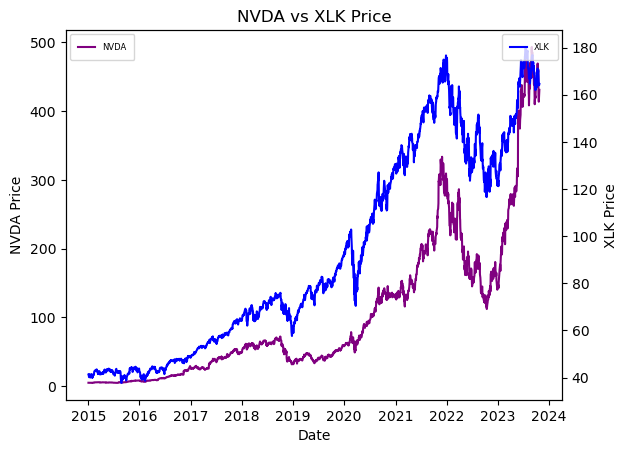

In [6]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

plt.show()

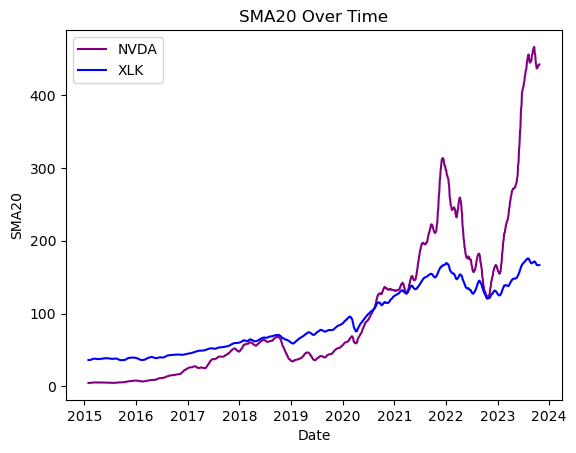

In [7]:
plt.plot(df['SMA20'], color='purple', label='NVDA')
plt.plot(df['xlk_SMA20'], color='blue', label='XLK')
plt.xlabel('Date')
plt.ylabel('SMA20')
plt.legend(loc='upper left')
plt.title('SMA20 Over Time')

plt.show()

In [8]:
'''plt.plot(df['log_return'])
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Log Return Over Time')

plt.show()'''

"plt.plot(df['log_return'])\nplt.xlabel('Date')\nplt.ylabel('Log Return')\nplt.title('Log Return Over Time')\n\nplt.show()"

In [8]:
# GLOBAL VARS
NUM_VARS = 9 
TIMESTEPS = 30 #10
DAYS_TO_PRED = 10

In [9]:
# Drop unwanted columns
df.dropna(inplace=True)
#df.drop(['Close', 'log_return'], axis=1, inplace=True)
df = df.iloc[:, 4: ]

# Assign a backup df for accessing later
backup_df = df[TIMESTEPS:]

In [10]:
df

,Adj Close,Volume,SMA20,xlk_SMA20,RSI_14,macd,upper_band,middle_band,lower_band
Date,,,,,,,,,
2015-02-09,4.893255,27394400,4.802377,36.253201,55.607995,0.040349,4.805432,4.875968,4.946504
2015-02-10,5.030112,22620400,4.817503,36.292403,62.465799,0.053752,4.791136,4.916305,5.041474
2015-02-11,4.996499,32083200,4.831309,36.340070,60.013565,0.060958,4.836567,4.947518,5.058468
2015-02-12,5.354249,67690400,4.862042,36.423375,72.422277,0.094448,4.697069,5.034434,5.371800
2015-02-13,5.356651,31008400,4.894576,36.541872,72.484014,0.119802,4.740996,5.126153,5.511310
...,...,...,...,...,...,...,...,...,...
2023-10-18,421.959991,62729400,440.559003,166.411501,39.805056,0.290370,415.615051,449.270001,482.924951
2023-10-19,421.010010,50123300,441.101003,166.546501,39.492472,-1.782978,406.865924,439.582001,472.298077
2023-10-20,413.869995,47638100,440.989502,166.523001,37.132274,-3.956651,397.478212,431.434003,465.389793


In [11]:
# Define function to split data into train, val, test
def split(dataset, days_to_test):
    
    # DAYS_TO_PRED rows will be removed for test data, remaining split .8 .2
    test_val_len = len(dataset) - days_to_test
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = dataset[: l_80], dataset[l_80 : test_val_len], dataset[test_val_len :]
    
    return train_data, val_data, test_data

In [14]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timesteps):

    x = []
    y = []
    
    for i in range(len(dataset) - timesteps):
        '''
        for e.g. timesteps = 20
        [add_x] --> [add_y]:
        for one var:
        [0, 1, 2, ... 20] --> [21]
        [1, 2, 3, ... 21] --> [22]

        for multiple vars:
        [[a1, b1, c1], [a2, b2, c2], [a3, b3, c3], ... [a20, b20, c20]] --> [a21, b21, c21]
        '''
        add_x = dataset[i : i + timesteps] # At i = 0, slice from 0 - timesteps
        add_y = dataset[i + timesteps]

        # Extract vars
        add_x = [lst for lst in add_x]

        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [15]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Create datasets
X_full, y_full = create_dataset(df, TIMESTEPS)

# Split data
X_train, X_val, X_test = split(X_full, DAYS_TO_PRED)
y_train, y_val, y_test = split(y_full, DAYS_TO_PRED)

# Shape should be (samples, timesteps, features)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1722, 30, 9), (1722, 9), (431, 30, 9), (431, 9), (10, 30, 9), (10, 9))

In [16]:
# Check if values are correct
X_train[1][-1] == y_train[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

## Stacked LSTM Implementation
LSTMs are a type of RNN that remember information over long periods of time, which allows us to work with non-stationary data. LSTMs are also able to pick up on patterns from large datasets, making them better suited for predicting stock prices. 

In [17]:
# GLOBAL VARS
EPOCHS = 8 #10 had overfitting
INPUT_SHAPE = (TIMESTEPS, NUM_VARS)
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

In [18]:
# Define model
model = keras.Sequential([

    keras.layers.LSTM(units=64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(NUM_VARS, activation='linear')
        
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

2023-10-24 23:26:54.113579: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-24 23:26:54.113604: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-24 23:26:54.113611: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-24 23:26:54.113651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 23:26:54.113668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            18944     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            4

In [21]:
# Train model
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/8
27/27 [==============================] - 139s 5s/step - loss: 0.0370 - accuracy: 0.6702 - val_loss: 0.0748 - val_accuracy: 0.1531
Epoch 2/8
27/27 [==============================] - 124s 5s/step - loss: 0.0125 - accuracy: 0.7549 - val_loss: 0.0366 - val_accuracy: 0.8051
Epoch 3/8
27/27 [==============================] - 138s 5s/step - loss: 0.0067 - accuracy: 0.8136 - val_loss: 0.0222 - val_accuracy: 0.8237
Epoch 4/8
27/27 [==============================] - 144s 5s/step - loss: 0.0058 - accuracy: 0.8171 - val_loss: 0.0207 - val_accuracy: 0.8237
Epoch 5/8
27/27 [==============================] - 154s 6s/step - loss: 0.0055 - accuracy: 0.8194 - val_loss: 0.0197 - val_accuracy: 0.8237
Epoch 6/8
27/27 [==============================] - 152s 6s/step - loss: 0.0052 - accuracy: 0.8223 - val_loss: 0.0192 - val_accuracy: 0.8237
Epoch 7/8
27/27 [==============================] - 150s 6s/step - loss: 0.0049 - accuracy: 0.8240 - val_loss: 0.0142 - val_accuracy: 0.8237
Epoch 8/8
27/27 [===

### Model Evaluation

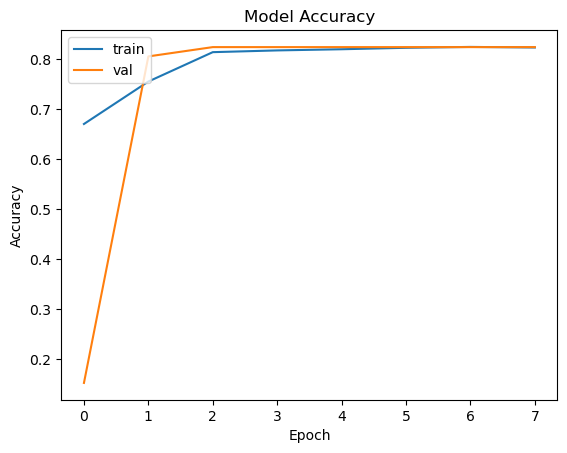

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

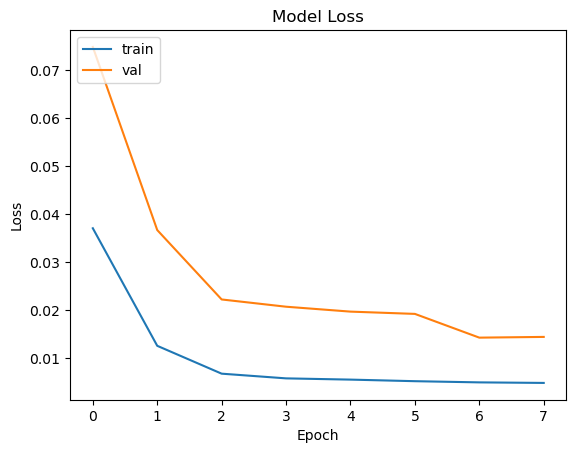

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [27]:
# Prediction on test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get original format
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

1/1 [==============================] - 0s 493ms/step


In [28]:
# GLOBAL VARIABLES
ADJ_CLOSE_INDEX = 0

In [29]:
# Extract Adj Close Col
train_predict = [rows[ADJ_CLOSE_INDEX] for rows in train_predict]
y_train = [rows[ADJ_CLOSE_INDEX] for rows in y_train]

test_predict = [rows[ADJ_CLOSE_INDEX] for rows in test_predict]
y_test = [rows[ADJ_CLOSE_INDEX] for rows in y_test]

In [30]:
train_results = pd.DataFrame(data={'Predictions': train_predict, 'Actual': y_train})
test_results = pd.DataFrame(data={'Predictions': test_predict, 'Actual': y_test})

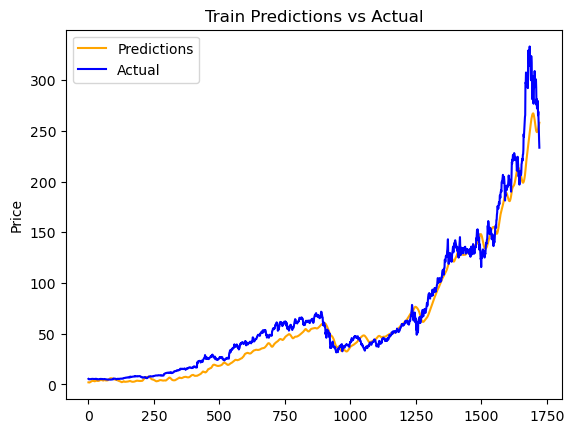

In [31]:
plt.plot(train_results['Predictions'], color='orange')
plt.plot(train_results['Actual'], color='blue')
plt.title('Train Predictions vs Actual')
plt.ylabel('Price')
plt.legend(['Predictions', 'Actual'], loc='upper left')

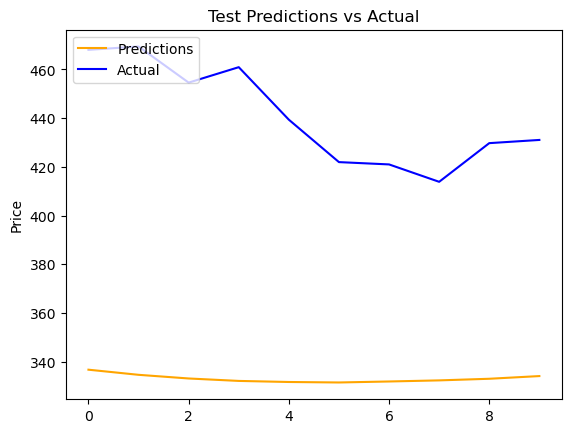

In [32]:
plt.plot(test_results['Predictions'], color='orange')
plt.plot(test_results['Actual'], color='blue')
plt.title('Test Predictions vs Actual')
plt.ylabel('Price')
plt.legend(['Predictions', 'Actual'], loc='upper left')

In [33]:
# Define Function to calculate rmse
def calc_rmse(actual, prediction):
    return mean_squared_error(actual, prediction, squared=False)

In [34]:
print(
    'Train RMSE:', calc_rmse(y_train, train_predict),'\n'
    'Test RMSE:', calc_rmse(y_test, test_predict)
    )

Train RMSE: 13.970188476196878 
Test RMSE: 109.53107420533095


### Make Predictions

In [35]:
# Define function to predict
def get_predictions(days, dataset):
    
    predictions = []

    # Select the last row which contains past TIMESTEPS rows of data.
    dataset = dataset[-1]
    
    for i in range(days):
        
        # Reshape data for prediction input
        dataset = np.reshape(dataset, (1, TIMESTEPS, NUM_VARS))

        prediction = model.predict(dataset)
        predictions.append(prediction)

        # Remove first day from window
        dataset = dataset[0][1:]

        # Add back to prediction input
        dataset = np.concatenate([dataset, prediction], axis=0)
    
    predictions = scaler.inverse_transform(dataset)
    predictions = pd.DataFrame(predictions)[-days:]
    return predictions


In [36]:
final_pred = get_predictions(DAYS_TO_PRED, X_test)

1/1 [==============================] - 0s 287ms/step


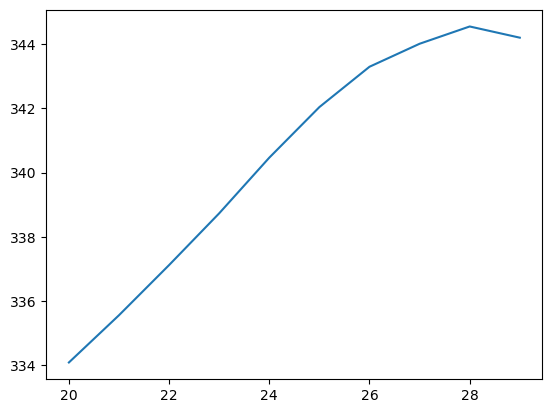

In [37]:
plt.plot(final_pred[ADJ_CLOSE_INDEX])

In [38]:
def get_prediction_df(dataset, start_date, end_date):

    df = dataset

    # Generate index from date range
    dates = pd.bdate_range(start=start_date, end=end_date)
    dates = pd.Series(data=dates).rename('Date')

    # Reset index of input data
    df.reset_index(inplace=True)

    # Add date column and set as index
    df = pd.concat([df, dates], axis=1)
    df.set_index('Date', inplace=True)

    return df


In [39]:
prediction_df = get_prediction_df(final_pred, start_date='10/25/2023', end_date='11/7/2023')

In [40]:
final_df = prediction_df[ADJ_CLOSE_INDEX].rename('Close')

In [34]:
#final_df.to_csv('Gareth_Chay_Impl_1.csv')